## Laboratory of Computational Physics mod. B at Phisics of Data, University of Padova

__Authors:__

- Valeria Fioroni (University of Padova)
- Matteo Guida (University of Padova)
- Philipp Zehetner (University of Padova, Ludwig Maximilian University of Munich)

__Supervised by:__

- Professor Marco Zanetti (University of Padova, CERN)
- Professor Stefano Lacaprara (University of Padova, BELLE2)

### Description 
---
> The goal of this project is to find the branching ratio of 
$B^0 \rightarrow \eta' K_S^0$

with :  
$\eta' \rightarrow \eta \; \pi^+ \pi^-$, <br>
$\eta \rightarrow \gamma \gamma$ and <br>
$K_S^0 \rightarrow \pi^+ \pi^-$<br>
in Monte Carlo simulation (Data Challenge)

To do this, we build a deep neural network (DNN) with Keras/Tensorflow using labelled data, optimize it and finally use it as a classifier on the Data Challenge

In [1]:
import os, sys, pprint
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
Testing = False # Uses only a small subset of the data and trains on fewer epochs. 
PCA_ON = False
Local_Philipp = False
Local_Valeria = False
VM = True

if Testing: print("For testing purpose only a small number of events are used")
if Local_Philipp : print("Paths are set to be run on Philipps Computer")
elif VM : print("Paths are set to run on the VM")

Paths are set to run on the VM


## 1. Reading and Cleaning Data

In this chapter we
- read relevant information from root files into pandas data frames
- clean our data sets by removing wrongly reconstructed signal and allowing only one true signal candidate per event
- apply a $5\sigma$ cut on the mass of the reconstructed $B^0$ on all candidates

In [3]:
# Define branches that we need for our analysis
Masses = ['B0_M', 'B0_ErrM', 'B0_SigM', 'B0_K_S0_M', 'B0_K_S0_ErrM', 'B0_K_S0_SigM', 'B0_etap_M', 'B0_etap_ErrM', 
          'B0_etap_SigM', 'B0_etap_eta_M', 'B0_etap_eta_ErrM', 'B0_etap_eta_SigM']
Kinetics_CMS = ['B0_Pcms', 'B0_etap_Pcms', 'B0_etap_eta_Pcms', 'B0_etap_eta_gamma0_Pcms', 'B0_etap_eta_gamma1_Pcms',
                'B0_etap_pi0_Pcms', 'B0_etap_pi1_Pcms', 'B0_K_S0_Pcms']
Other_Kinetics = ['B0_deltae', 'B0_mbc']
DecayAngles = ['B0_decayAngle__bo0__bc', 'B0_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo0__bc',
               'B0_etap_decayAngle__bo1__bc', 'B0_etap_decayAngle__bo2__bc']
Positions = ['B0_X', 'B0_ErrX', 'B0_Y', 'B0_ErrY', 'B0_Z', 'B0_ErrZ', 'B0_Rho',  
             'B0_etap_X', 'B0_etap_ErrX', 'B0_etap_Y', 'B0_etap_ErrY', 
             'B0_etap_Z', 'B0_etap_ErrZ', 'B0_etap_Rho',
             'B0_etap_eta_X', 'B0_etap_eta_ErrX', 'B0_etap_eta_Y',
             'B0_etap_eta_ErrY', 'B0_etap_eta_Z', 'B0_etap_eta_ErrZ', 'B0_etap_eta_Rho',
             'B0_etap_pi0_X', 'B0_etap_pi0_ErrX', 'B0_etap_pi0_Y', 'B0_etap_pi0_ErrY', 
             'B0_etap_pi0_Z', 'B0_etap_pi0_ErrZ', 'B0_etap_pi0_Rho', 
             'B0_etap_pi1_X', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Y', 'B0_etap_pi1_ErrY', 
             'B0_etap_pi1_Z', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Rho', 
             'B0_K_S0_X', 'B0_K_S0_ErrX', 'B0_K_S0_Y', 'B0_K_S0_ErrY', 'B0_K_S0_Z',
             'B0_K_S0_ErrZ', 'B0_K_S0_Rho', 
             'B0_cosAngleBetweenMomentumAndVertexVector', 'B0_distance', 'B0_significanceOfDistance',
             'B0_dr', 'B0_etap_pi0_dr', 'B0_etap_pi1_dr', 'B0_K_S0_dr']
Vertex_Training = ['B0_VtxPvalue', 'B0_etap_VtxPvalue', 'B0_etap_eta_VtxPvalue', 'B0_etap_pi0_VtxPvalue',
                   'B0_etap_pi1_VtxPvalue', 'B0_K_S0_VtxPvalue', ]
Continuum_Suppression_Training = ['B0_TrCSMVA']

Training = Kinetics_CMS + Masses + Other_Kinetics + Continuum_Suppression_Training + Positions + DecayAngles + Vertex_Training
Important = Training + ['B0_isSignal', 'evt_no']

In [4]:
def memory(df):
    print(str((round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))),"Mb")

In [5]:
%%time
from root_pandas import read_root

if Local_Philipp and not VM : 
    path = '/home/philipp/Desktop/Project/DATA/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Continuous/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Peaking/*.root'))
    
elif VM and not Local_Philipp : 
    path = '/home/Students/DataBelle2_all/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    
elif Local_Matteo:  
    path = '/home/guida/Scrivania/PROJECT_2/DataBelle2'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    
elif Local_Valeria:  
    path = '/home/utente/Scrivania/Progetto LCP-B/DataBelle2/'
    SFiles = glob.glob(os.path.join(path, 'Signal/*.root'))
    CFiles = glob.glob(os.path.join(path, 'Background/Continuum/*.root'))
    PFiles = glob.glob(os.path.join(path, 'Background/Peaking/*.root'))
    

Signal = pd.concat((read_root(f, 'B0', columns=Important) for f in SFiles))
Signal = Signal[Signal['B0_isSignal']==1].reset_index(drop=True)
Continuum_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in CFiles))
Peaking_bkg = pd.concat((read_root(f, 'B0', columns=Important) for f in PFiles))

print ("Memory used by Signal", memory(Signal))
print ("Memory used by Continuum", memory(Continuum_bkg))
print ("Memory used by Peaking \n", memory(Peaking_bkg))

print("Peaking shape : ",Peaking_bkg.shape)
print("Continuum shape : ",Continuum_bkg.shape)
print("Signal shape : ",Signal.shape)

Welcome to JupyROOT 6.16/00


/home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.16.4 is currently installed but you installed root_numpy against numpy 1.9.3. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


71.3 Mb
Memory used by Signal None
77.18 Mb
Memory used by Continuum None
0.49 Mb
Memory used by Peaking 
 None
Peaking shape :  (1490, 85)
Continuum shape :  (232554, 85)
Signal shape :  (219897, 85)
CPU times: user 20.6 s, sys: 613 ms, total: 21.3 s
Wall time: 21.3 s


### $5\sigma$ Cut on Reconstructed $B^0$ Mass

The reconstructed mass of the $B^0$ will differ for various reasons: 

- If an event is correctly reconstructed detector inaccuracies of all measured decay particles will add up. The estimated error for each candidate due to this can be found in the branch *B0_ErrM* and is part of our data frame. 
- If the event however is not correctly reconstructed the $B^0$ mass is not necessarily a meaningful quantity an can be far of the desired [PDG](http://pdg.lbl.gov/) value. 

By applying a generous $5\sigma$ cut we already lose a significant amount of background

In [ ]:
"""#Masses from PDG
M_B0 = [5.27955, 0.00026]
M_K0 = [0.497611, 0.000013]
M_etap = [0.95778, 0.00006]
M_eta = [0.547862, 0.000017]

#Require the B0 mass to be within 5 sigma from PDG value
Signal = Signal[abs(Signal['B0_M'] - M_B0[0]) < 5 * Signal['B0_ErrM']]
print("Signal : ",Signal.shape)

Continuum_bkg = Continuum_bkg[abs(Continuum_bkg['B0_M'] - M_B0[0]) < 5 * Continuum_bkg['B0_ErrM']]
print("Continuum : ", Continuum_bkg.shape)

Peaking_bkg = Peaking_bkg[abs(Peaking_bkg['B0_M'] - M_B0[0]) < 5 * Peaking_bkg['B0_ErrM']]
print("Peaking : ",Peaking_bkg.shape)
"""

In [32]:
#Signal: In case of more than 1 candidate per event select the first one occuring
Mask_duplicated = Signal.duplicated(subset='evt_no', keep='first')
Mask_duplicated=np.logical_not(Mask_duplicated)
Signal=Signal[Mask_duplicated]
Signal.reset_index(drop=True, inplace=True)

print("Signal : ",Signal.shape)
print(Signal['evt_no'].nunique())

Signal=Signal[Training]
Continuum_bkg=Continuum_bkg[Training]
Peaking_bkg=Peaking_bkg[Training]

Signal :  (218596, 86)
218596


In [7]:
# lines_selected=50000
# Signal=Signal[0:lines_selected]
# Continuum_bkg=Continuum_bkg[0:lines_selected]

memory(Signal)
memory(Continuum_bkg)
memory(Peaking_bkg)
print("Peaking : ",Peaking_bkg.shape)
print("Continuum : ",Continuum_bkg.shape)
print("Signal : ",Signal.shape)
print("% of peaking on the entire dataset : ",round((Peaking_bkg.shape[0])/(Peaking_bkg.shape[0]+Continuum_bkg.shape[0]+Signal.shape[0])*100,3))

71.3 Mb
77.18 Mb
0.49 Mb
Peaking :  (1490, 85)
Continuum :  (232554, 85)
Signal :  (219897, 85)
% of peaking on the entire dataset :  0.328


## 2. Data Preprocessing

In this chapter we
- label our data
- turn the label into one-hot vectors as this format is needed by Keras
- split signal, continuum and peaking separatly into training (50%), valdation (30%) and testing (20%) to assure to have a fair amount of each type in all sets
- combine and shuffle signal, continuum and peaking for training, validation and testing, making sure that the labels are shuffled with the same permutation as the data
- standardize the data (removing mean and scaling the standard deviation to 1)
- perform a Principal Component Analysis (PCA) and use the principal components necessary for 99% of the variance

In [8]:
from random import seed
from random import randint

n_seed=1234
seed(n_seed)

In [9]:
Signal['Type'] = 2
Continuum_bkg['Type'] = 1
Peaking_bkg['Type'] = 0

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

#SIGNAL: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Signal.drop('Type',axis=1)
Y = Signal['Type']
#Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_S, X_test_val_S, Y_train_S, Y_test_val_S = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_S
Y = Y_test_val_S
X_validation_S, X_test_S, Y_validation_S, Y_test_S = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_S)
del(Y_test_val_S)

#CONTINUUM BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Continuum_bkg.drop('Type',axis=1)
Y = Continuum_bkg['Type']
#Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_C, X_test_val_C, Y_train_C, Y_test_val_C = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_C
Y = Y_test_val_C
X_validation_C, X_test_C, Y_validation_C, Y_test_C = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_C)
del(Y_test_val_C)

#PEAKING BKG: Train, Validation and test split (50%, 30%, 20%)
#Dataset divided into 50% of train data and 50% for validation and test
X = Peaking_bkg.drop('Type',axis=1)
Y = Peaking_bkg['Type']
##Y = to_categorical(Y, num_classes=3) # Binarize the labels
X_train_P, X_test_val_P, Y_train_P, Y_test_val_P = train_test_split(X, Y, train_size=0.5,random_state=randint(10**6,10**9))
#validation and test set divided into 30% for validation and 20% for test
X = X_test_val_P
Y = Y_test_val_P
X_validation_P, X_test_P, Y_validation_P, Y_test_P = train_test_split(X, Y, train_size=0.6,random_state=randint(10**6,10**9))
del(X_test_val_P)
del(Y_test_val_P)

"""del(Signal)
del(Peaking_bkg)
del(Continuum_bkg)"""


Using TensorFlow backend.


'del(Signal)\ndel(Peaking_bkg)\ndel(Continuum_bkg)'

In [11]:
# Get ndArray of all column names 
columnsNamesArr = X_train_S.columns.values
columnsNamesArr

array(['B0_etap_eta_VtxPvalue', 'B0_etap_ErrY', 'B0_ErrX', 'B0_K_S0_ErrY',
       'B0_etap_eta_Y', 'B0_etap_decayAngle__bo1__bc',
       'B0_etap_eta_gamma1_Pcms', 'B0_etap_M', 'B0_Rho', 'B0_etap_eta_M',
       'B0_SigM', 'B0_etap_VtxPvalue', 'B0_ErrM', 'B0_K_S0_dr',
       'B0_distance', 'B0_significanceOfDistance', 'B0_etap_pi1_Y',
       'B0_K_S0_Rho', 'B0_etap_eta_Z', 'B0_M', 'B0_dr',
       'B0_etap_pi1_ErrY', 'B0_Pcms', 'B0_etap_pi1_ErrZ', 'B0_etap_pi1_Z',
       'B0_etap_pi0_Z', 'B0_etap_pi1_ErrX', 'B0_etap_pi1_Pcms',
       'B0_etap_pi0_dr', 'evt_no', 'B0_etap_eta_Pcms', 'B0_etap_SigM',
       'B0_X', 'B0_ErrY', 'B0_etap_ErrM', 'B0_etap_pi0_VtxPvalue',
       'B0_etap_eta_ErrM', 'B0_VtxPvalue', 'B0_deltae',
       'B0_etap_eta_ErrY', 'B0_etap_pi1_dr', 'B0_etap_pi0_X', 'B0_Z',
       'B0_etap_Rho', 'B0_isSignal', 'B0_etap_eta_ErrX', 'B0_K_S0_ErrX',
       'B0_K_S0_SigM', 'B0_K_S0_Pcms', 'B0_etap_pi0_ErrX',
       'B0_etap_decayAngle__bo2__bc', 'B0_etap_eta_SigM', 'B0_K_S0_Z',
  

In [12]:
#Define Training, Validation and Test datasets
X_Train=np.concatenate((X_train_S, X_train_C, X_train_P), axis=0)
X_Validation=np.concatenate((X_validation_S, X_validation_C, X_validation_P), axis=0)
X_Test=np.concatenate((X_test_S, X_test_C, X_test_P), axis=0)


Y_Train=np.concatenate((Y_train_S, Y_train_C, Y_train_P), axis=0)
Y_Validation=np.concatenate((Y_validation_S, Y_validation_C, Y_validation_P), axis=0)
Y_Test=np.concatenate((Y_test_S, Y_test_C, Y_test_P), axis=0)
Ỳ_Test_not_encoded=Y_Test #needed for cut value analysis

Y_Train=to_categorical(Y_Train, num_classes=3) # Binarize the labels
Y_Validation=to_categorical(Y_Validation, num_classes=3) # Binarize the labels
Y_Test=to_categorical(Y_Test, num_classes=3) # Binarize the labels

print(X_Train.shape)
print(X_Validation.shape)
print(X_Test.shape)

print("X Train shape : ", X_Train.shape)
print("X Validation shape : ",X_Validation.shape)
print("X Test shape : ",X_Test.shape)
n_classes = Y_Train.shape[1]

(226970, 85)
(136182, 85)
(90789, 85)
X Train shape :  (226970, 85)
X Validation shape :  (136182, 85)
X Test shape :  (90789, 85)


In [13]:
X_train_S

,B0_etap_eta_VtxPvalue,B0_etap_ErrY,B0_ErrX,B0_K_S0_ErrY,B0_etap_eta_Y,B0_etap_decayAngle__bo1__bc,B0_etap_eta_gamma1_Pcms,B0_etap_M,B0_Rho,B0_etap_eta_M,...,B0_etap_X,B0_etap_eta_X,B0_TrCSMVA,B0_etap_decayAngle__bo0__bc,B0_etap_ErrZ,B0_K_S0_M,B0_etap_pi0_Y,B0_etap_Pcms,B0_etap_pi1_X,B0_K_S0_Y
2107,0.770381,0.0,0.000850,0.401968,0.0,-0.320722,1.234126,0.960623,0.009601,0.544716,...,0.0,0.0,2.349126,0.568833,0.0,0.494101,-0.020521,2.536680,-0.010269,8.572335
644,0.139375,0.0,0.000720,0.035056,0.0,-0.160324,1.125199,0.948931,0.003671,0.564279,...,0.0,0.0,2.313254,0.953772,0.0,0.500138,0.007314,2.631554,-0.022959,-2.032909
138267,0.643668,0.0,0.000582,0.004323,0.0,0.218275,0.595795,0.956213,0.004589,0.552958,...,0.0,0.0,2.364811,-0.311942,0.0,0.499037,-0.001592,2.482726,-0.002935,0.406086
200523,0.000030,0.0,0.000764,0.062676,0.0,0.807357,0.498164,0.959175,0.004077,0.507972,...,0.0,0.0,2.622338,-0.077033,0.0,0.498328,-0.003910,2.425400,0.009840,1.168977
51852,0.834641,0.0,0.000694,0.030436,0.0,-0.609761,1.455146,0.956288,0.007173,0.551391,...,0.0,0.0,3.099716,0.080959,0.0,0.495337,0.007068,2.562650,0.000037,2.207759
206082,0.762149,0.0,0.009853,0.109681,0.0,0.700303,1.022070,0.961185,0.002137,0.543855,...,0.0,0.0,1.769954,-0.814533,0.0,0.495192,-0.005752,2.575200,-0.022751,-2.970830
179503,0.007797,0.0,0.000777,0.065711,0.0,-0.541838,0.847562,0.960111,0.002147,0.520622,...,0.0,0.0,2.289236,0.332421,0.0,0.495174,-0.028242,2.481958,0.001178,-3.018814
1564,0.046574,0.0,0.000797,0.183282,0.0,0.310137,1.023682,0.956367,0.003690,0.571077,...,0.0,0.0,3.119496,-0.178330,0.0,0.496574,0.004370,2.374726,0.002124,-1.273415
17618,0.844039,0.0,0.000619,0.008391,0.0,0.424302,0.392071,0.956217,0.006595,0.545575,...,0.0,0.0,-0.350353,-0.477509,0.0,0.499789,-0.012056,2.440856,0.002358,-0.777899
140095,0.955213,0.0,0.000717,0.012355,0.0,0.994452,0.085674,0.954210,0.002602,0.546623,...,0.0,0.0,-2.028774,-0.832658,0.0,0.484471,0.002930,2.591331,-0.001341,0.463686


In [14]:
X_Train1 = pd.DataFrame(X_Train, columns = columnsNamesArr)
X_Train1

,B0_etap_eta_VtxPvalue,B0_etap_ErrY,B0_ErrX,B0_K_S0_ErrY,B0_etap_eta_Y,B0_etap_decayAngle__bo1__bc,B0_etap_eta_gamma1_Pcms,B0_etap_M,B0_Rho,B0_etap_eta_M,...,B0_etap_X,B0_etap_eta_X,B0_TrCSMVA,B0_etap_decayAngle__bo0__bc,B0_etap_ErrZ,B0_K_S0_M,B0_etap_pi0_Y,B0_etap_Pcms,B0_etap_pi1_X,B0_K_S0_Y
0,7.703807e-01,0.0,0.000850,0.401968,0.0,-0.320722,1.234126,0.960623,0.009601,0.544716,...,0.0,0.0,2.349126,0.568833,0.0,0.494101,-0.020521,2.536680,-1.026854e-02,8.572335
1,1.393745e-01,0.0,0.000720,0.035056,0.0,-0.160324,1.125199,0.948931,0.003671,0.564279,...,0.0,0.0,2.313254,0.953772,0.0,0.500138,0.007314,2.631554,-2.295909e-02,-2.032909
2,6.436684e-01,0.0,0.000582,0.004323,0.0,0.218275,0.595795,0.956213,0.004589,0.552958,...,0.0,0.0,2.364811,-0.311942,0.0,0.499037,-0.001592,2.482726,-2.934942e-03,0.406086
3,3.027391e-05,0.0,0.000764,0.062676,0.0,0.807357,0.498164,0.959175,0.004077,0.507972,...,0.0,0.0,2.622338,-0.077033,0.0,0.498328,-0.003910,2.425400,9.839713e-03,1.168977
4,8.346408e-01,0.0,0.000694,0.030436,0.0,-0.609761,1.455146,0.956288,0.007173,0.551391,...,0.0,0.0,3.099716,0.080959,0.0,0.495337,0.007068,2.562650,3.657752e-05,2.207759
5,7.621492e-01,0.0,0.009853,0.109681,0.0,0.700303,1.022070,0.961185,0.002137,0.543855,...,0.0,0.0,1.769954,-0.814533,0.0,0.495192,-0.005752,2.575200,-2.275070e-02,-2.970830
6,7.796651e-03,0.0,0.000777,0.065711,0.0,-0.541838,0.847562,0.960111,0.002147,0.520622,...,0.0,0.0,2.289236,0.332421,0.0,0.495174,-0.028242,2.481958,1.178024e-03,-3.018814
7,4.657388e-02,0.0,0.000797,0.183282,0.0,0.310137,1.023682,0.956367,0.003690,0.571077,...,0.0,0.0,3.119496,-0.178330,0.0,0.496574,0.004370,2.374726,2.124050e-03,-1.273415
8,8.440395e-01,0.0,0.000619,0.008391,0.0,0.424302,0.392071,0.956217,0.006595,0.545575,...,0.0,0.0,-0.350353,-0.477509,0.0,0.499789,-0.012056,2.440856,2.357570e-03,-0.777899
9,9.552132e-01,0.0,0.000717,0.012355,0.0,0.994452,0.085674,0.954210,0.002602,0.546623,...,0.0,0.0,-2.028774,-0.832658,0.0,0.484471,0.002930,2.591331,-1.341375e-03,0.463686


In [15]:
#shuffle the dataset
permutation = np.random.permutation(X_Train.shape[0])
X_Train = X_Train[permutation]
Y_Train = Y_Train[permutation]

permutation = np.random.permutation(X_Validation.shape[0])
X_Validation = X_Validation[permutation]
Y_Validation = Y_Validation[permutation]

permutation = np.random.permutation(X_Test.shape[0])
X_Test = X_Test[permutation]
Y_Test = Y_Test[permutation]

In [16]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = ss.fit_transform(X_Train)
X_Test = ss.transform(X_Test)
X_Validation = ss.transform(X_Validation)

In [17]:
"""from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_Train = pd.DataFrame(ss.fit_transform(X_Train),columns = X_Train.columns)
X_Test = pd.DataFrame(ss.fit_transform(X_Test),columns = X_Test.columns)
X_Validation = pd.DataFrame(ss.fit_transform(X_Validation),columns = X_Validation.columns)"""

'from sklearn.preprocessing import StandardScaler\n\nss = StandardScaler()\nX_Train = pd.DataFrame(ss.fit_transform(X_Train),columns = X_Train.columns)\nX_Test = pd.DataFrame(ss.fit_transform(X_Test),columns = X_Test.columns)\nX_Validation = pd.DataFrame(ss.fit_transform(X_Validation),columns = X_Validation.columns)'

## PCA

Principal component analysis is a method often used to reduce the dimensionality of a data set. Orthogonal transformations are performed on the data set to find the directions with the highest variance. The rotated features (principal components) are sorted in descending variance. The assumption made is, that high variance corresponds to more information and little variance can be neglected as noise.

In our example we require to keep 99% of the total variance and thus can reduce the number of components from 83 to 50

11 variables explain 50% of the variance
37 variables explain 90% of the variance
43 variables explain 95% of the variance
52 variables explain 99% of the variance


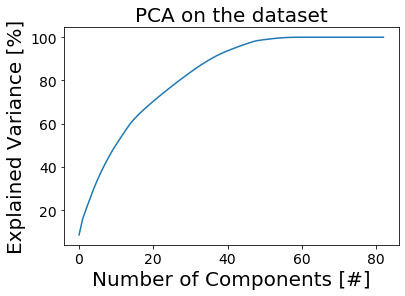

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline


pca = PCA(n_components=len(Training))
pcTrain = pd.DataFrame(data = pca.fit_transform(X_Train))
pcTest = pd.DataFrame(data = pca.transform(X_Test))
pcValidation = pd.DataFrame(data = pca.transform(X_Validation))

T50, T90, T95, T99, = False, False, False, False
for i in range(len(pca.explained_variance_ratio_)) : 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.5 and T50 ==False) : 
        print(str(i+1) + ' variables explain 50% of the variance')
        T50 = True
        n_50 = i + 1 
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.9 and T90 ==False) : 
        print(str(i+1) + ' variables explain 90% of the variance')
        T90 = True
        n_90 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.95 and T95 ==False) : 
        print(str(i+1) + ' variables explain 95% of the variance')
        T95 = True
        n_95 = i + 1
    if (sum(pca.explained_variance_ratio_[:i+1]) > 0.99 and T99 ==False) : 
        print(str(i+1) + ' variables explain 99% of the variance')
        T99 = True
        n_99 = i + 1
        
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.title('PCA on the dataset',fontsize=20)
plt.xlabel('Number of Components [#]',fontsize=20)
plt.tick_params(labelsize=14)
plt.ylabel('Explained Variance [%]',fontsize=20)
plt.show()
    
if not PCA_ON :  
    pcTrain = X_Train
    pcTest = X_Test
    pcValidation = X_Validation

In [19]:
if PCA_ON : 
    pca = PCA(n_components=n_99)
    pcTrain = pca.fit_transform(X_Train)
    pcTest = pd.DataFrame(data = pca.transform(X_Test))
    pcValidation = pd.DataFrame(data = pca.transform(X_Validation))
    print ("Input Dimension has been reduced to ", n_99)
else : 
    input_dim = 83
    print("Input Dimension has not been reduced and no PCA has been performed")

Input Dimension has not been reduced and no PCA has been performed


## 3. Create the Neural Network 

In [22]:
#optimizer = ['SGD', 'Adam']
#optimizer = ['SGD']
optimizer = ['SGD', 'Adam',' AdaMax']
#epochs = [10, 30]
epochs = [15]
if Testing : epochs = [1, 2]
batch_size = [100, 1000]
architectures = [ [30, 70, 30], [50, 100, 100, 50] ] 
#architectures = [[50, 100,100,50]] 
#activation = ['relu', 'elu']
#activation = ['elu']
activation = ['elu', 'leakyrelu', 'relu', 'sigmoid']

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier

def build_DNN(optimizer='adam', activation='elu'):
    model = Sequential()
    model.add(Dropout(0.3, input_shape=(pcTrain.shape[1],)))
    model.add(Dense(layers[0], input_shape=(pcTrain.shape[1],), activation='elu'))
    for i in range(1,len(layers)):
        model.add(Dense(layers[i], activation='elu', kernel_constraint=maxnorm(3)))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def print_results() :
    print("Layers: ", layers)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params): 
        print("%f (%f) with %r" % (mean, stdev, param))


In [24]:
from sklearn.model_selection import GridSearchCV

results = []
grids = []
for architecture in architectures : 
    layers = architecture
    print("Using architecture: ", layers)
    model = KerasClassifier(build_fn=build_DNN, batch_size=1000, epochs=2)
    param_grid = dict(epochs=epochs, batch_size=batch_size,
                      activation=activation, optimizer=optimizer)
    grid = GridSearchCV(estimator=model, param_grid=param_grid,
                        n_jobs=-1, pre_dispatch=8,cv=5)
    grid_result = grid.fit(pcTrain, Y_Train)
    results.append(grid_result)
    grids.append(grid)
    print_results()

Using architecture:  [30, 70, 30]


KeyboardInterrupt: 

Epoch 1/15

   100/181576 [..............................] - ETA: 3:56:00 - loss: 1.7145 - acc: 0.1900Epoch 1/15

   100/181576 [..............................] - ETA: 3:55:25 - loss: 1.2943 - acc: 0.3500Epoch 1/15

  1000/181576 [..............................] - ETA: 23:39 - loss: 1.1856 - acc: 0.4320  Epoch 1/15

   700/181576 [..............................] - ETA: 33:48 - loss: 1.1932 - acc: 0.4043  Epoch 1/15

   100/181576 [..............................] - ETA: 3:56:08 - loss: 1.2744 - acc: 0.3200Epoch 1/15

   100/181576 [..............................] - ETA: 3:56:45 - loss: 1.4593 - acc: 0.2800Epoch 1/15

   800/181576 [..............................] - ETA: 29:36 - loss: 1.1511 - acc: 0.3950  Epoch 1/15

181576/181576 [==============================] - 20s 111us/step - loss: 0.0616 - acc: 0.9815

179800/181576 [============================>.] - ETA: 0s - loss: 0.0603 - acc: 0.9826Epoch 2/15

181576/181576 [==============================] - 20s 112us/step - loss: 0.0621 - ac

Using TensorFlow backend.
W0721 16:17:09.909955 140255023224640 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

Using TensorFlow backend.
W0721 16:17:09.909954 140299735820096 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 16:17:09.930808 140299735820096 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 16:17:09.930817 140255023224640 deprecation_wrapper.py:119] From /home/Students/anaconda3/envs/BelleAnalysis/lib/

In [23]:
scores = []
params = []
for result in results : 
    scores.append(result.best_score_)
    params.append(result.best_params_)
    pprint.pprint(result.best_score_)
    pprint.pprint(result.best_params_)

0.9973388578931986
{'activation': 'leakyrelu',
 'batch_size': 100,
 'epochs': 15,
 'optimizer': 'Adam'}
0.9969952007555807
{'activation': 'relu', 'batch_size': 1000, 'epochs': 15, 'optimizer': 'SGD'}


### Evaluate the best Network

In [24]:
Best_Score = max(scores) # Best Score: 
Best_Params = params[scores.index(Best_Score)]
Best_Arch = architectures[scores.index(Best_Score)]
layers = Best_Arch
Best_Model = build_DNN(optimizer = Best_Params['optimizer'],
                       activation = Best_Params['activation'])
Best_Model.fit(pcTrain, Y_Train, batch_size = Best_Params['batch_size'],
               epochs = Best_Params['epochs'])

Epoch 1/15
226970/226970 [==============================] - 25s 109us/step - loss: 0.0511 - acc: 0.9859
Epoch 2/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0355 - acc: 0.9907
Epoch 3/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0331 - acc: 0.9911
Epoch 4/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0321 - acc: 0.9916
Epoch 5/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0305 - acc: 0.9922
Epoch 6/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0298 - acc: 0.9922
Epoch 7/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0284 - acc: 0.9927
Epoch 8/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0280 - acc: 0.9929
Epoch 9/15
226970/226970 [==============================] - 14s 61us/step - loss: 0.0271 - acc: 0.9931
Epoch 10/15
226970/226970 [==============================] - 14s 60us/st

In [25]:
print("Evaluation Train", Best_Model.evaluate(pcTrain, Y_Train))
print("Evaluation Validation", Best_Model.evaluate(pcValidation, Y_Validation))
print("Evaluation Test", Best_Model.evaluate(pcTest, Y_Test))

226970/226970 [==============================] - 31s 138us/step
Evaluation Train [0.07918641184456113, 0.987945543463894]
136182/136182 [==============================] - 16s 118us/step
Evaluation Validation [0.0793760941127098, 0.9876048229575127]
90789/90789 [==============================] - 11s 117us/step
Evaluation Test [0.07989397904887127, 0.987751820154424]


In [26]:
train_prediction = Best_Model.predict(pcTrain)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if train_pred[i].all() == Y_Train[i].all() : N_true += 1
    else : N_false += 1
        

print("Training:")
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Training:
Accuracy =  1.0
N_true:  226970
N_false:  0


In [27]:
train_prediction = Best_Model.predict(pcValidation)
indeces = np.argmax(train_prediction, axis=1)
train_pred = to_categorical(indeces, num_classes=3)

N_true = 0
N_false = 0
for i in range(len(train_pred)) : 
    if np.array_equal(Y_Validation[i], train_pred[i]) : N_true += 1
    else : N_false += 1
        

print ("Validation:")        
print ("Accuracy = ", N_true/(N_true+N_false))
print ("N_true: ", N_true)
print ("N_false: ", N_false)

Validation:
Accuracy =  0.9876048229575127
N_true:  134494
N_false:  1688


In [28]:
print("Trainig Error : ",1-Best_Model.evaluate(pcTrain, Y_Train)[1])
print("Validation Error : ",1-Best_Model.evaluate(pcValidation, Y_Validation)[1])

226970/226970 [==============================] - 27s 118us/step
Trainig Error :  0.01205445653610604
136182/136182 [==============================] - 16s 120us/step
Validation Error :  0.012395177042487271


In [29]:
y_score = Best_Model.predict(pcValidation)

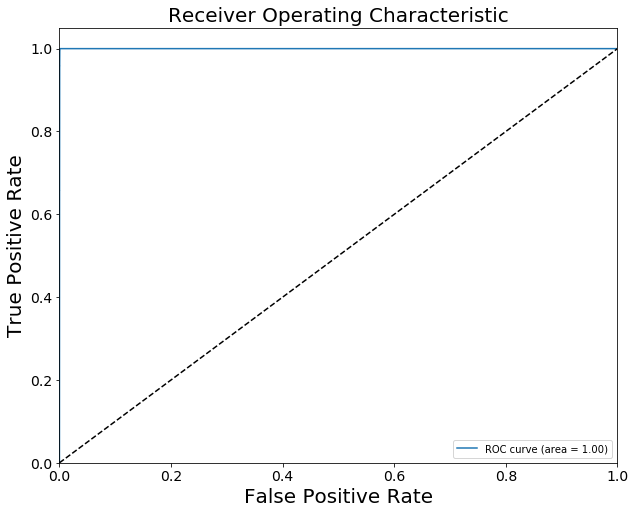

In [30]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_Validation[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
fig = plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver Operating Characteristic',fontsize=20)
plt.tick_params(labelsize=14)
plt.legend(loc="lower right")
fig.set_size_inches(10, 8)
plt.show()

### Confusion Matrix

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=30,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize=15)

    plt.ylabel('TRUE LABEL',fontsize=20)
    plt.xlabel('PREDICTED LABEL',fontsize=20)
    fig.set_size_inches(10, 8)
    plt.tight_layout()

In [21]:
from sklearn.metrics import confusion_matrix

In [27]:
#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_val_predict = Best_Model.predict_proba(X_Validation)
Y_val_single_col = np.where(Y_Validation==1)[1]
Y_val_mo = pd.get_dummies(Y_val_single_col[:])
Y_val_predict_mo = Y_val_predict.round()
cnf_matrix = confusion_matrix(Y_val_mo.values.argmax(axis=1), Y_val_predict_mo.argmax(axis=1))

NameError: name 'Best_Model' is not defined

In [33]:
print(pd.value_counts(Y_val_predict_mo.argmax(axis=1)))

1    70075
2    64595
0     1512
dtype: int64


In [34]:
cnf_matrix

array([[  115,   301,    31],
       [    5, 69761,     0],
       [ 1392,    13, 64564]])

Normalized confusion matrix
[[2.57270694e-01 6.73378076e-01 6.93512304e-02]
 [7.16681478e-05 9.99928332e-01 0.00000000e+00]
 [2.11008201e-02 1.97062257e-04 9.78702118e-01]]


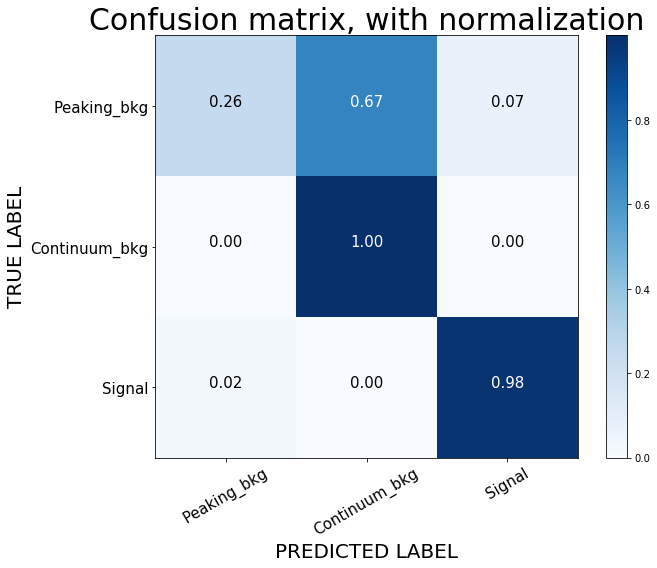

In [35]:
import itertools
plot_confusion_matrix(cnf_matrix, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title='Confusion matrix, with normalization')

### Confusion Matrix Training Set

In [36]:
#Y_train_predict = Best_Model.predict_proba(pcTrain)
Y_train_predict = Best_Model.predict_proba(X_Train)
Y_train_single_col = np.where(Y_Train==1)[1]
Y_train_mo = pd.get_dummies(Y_train_single_col[:])
Y_train_predict_mo = Y_train_predict.round()
cnf_matrix_train = confusion_matrix(Y_train_mo.values.argmax(axis=1), Y_train_predict_mo.argmax(axis=1))

In [37]:
cnf_matrix_train

array([[   211,    490,     44],
       [     4, 116273,      0],
       [  2244,     23, 107681]])

Confusion Matrix for Ttraining set
Normalized confusion matrix
[[2.83221477e-01 6.57718121e-01 5.90604027e-02]
 [3.44006123e-05 9.99965599e-01 0.00000000e+00]
 [2.04096482e-02 2.09189799e-04 9.79381162e-01]]


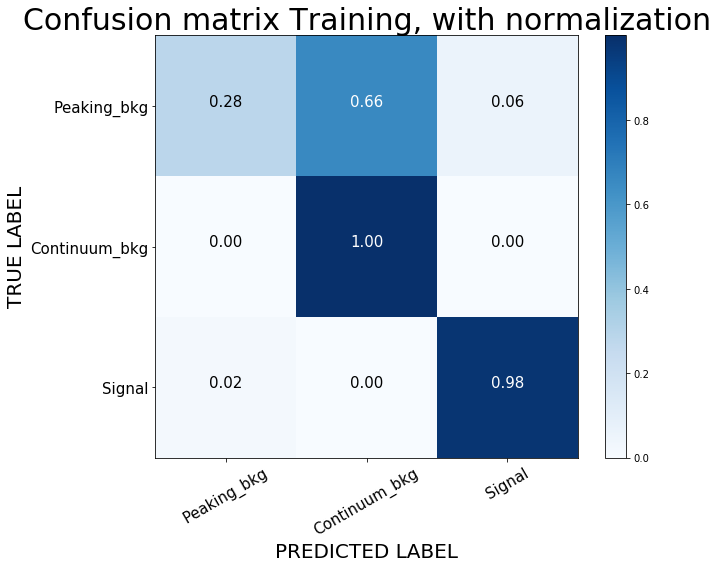

In [38]:
print("Confusion Matrix for Ttraining set")
plot_confusion_matrix(cnf_matrix_train, classes=['Peaking_bkg', 'Continuum_bkg', 'Signal'],
                       title='Confusion matrix Training, with normalization')

### Saving Model, weights, standard scaler and PCA if used

In [33]:
import joblib

In [39]:
joblib.dump(ss, 'Scaler.pkl')
if PCA_ON :     joblib.dump(pca, 'PCA.pkl')
Best_Model.save("Best_Model.h5")

In [40]:
Best_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_123 (Dropout)        (None, 85)                0         
_________________________________________________________________
dense_610 (Dense)            (None, 30)                2580      
_________________________________________________________________
dense_611 (Dense)            (None, 70)                2170      
_________________________________________________________________
dense_612 (Dense)            (None, 30)                2130      
_________________________________________________________________
dense_613 (Dense)            (None, 3)                 93        
Total params: 6,973
Trainable params: 6,973
Non-trainable params: 0
_________________________________________________________________


### Try Loading the model

In [41]:
!ls

50_100_100_50			   Keras_Analysis.ipynb
anaconda3			   Models
Anaconda3-2019.03-Linux-x86_64.sh  Philipp
ANALISIS_1.ipynb		   Quitegood-Copy1.ipynb
ANALYSIS1.ipynb			   Quitegood-Copy2.ipynb
ANALYSIS-Copy1.ipynb		   Quitegood-Copy3.ipynb
ANALYSIS.ipynb			   Quitegood.ipynb
Belle-II-analysis		   Scaler.pkl
Best_Model.h5			   Test_notebooks
DataBelle2_all			   TIDY-Copy1.ipynb
environment.yml			   TIDY.ipynb
Keras_Analysis-Copy1.ipynb	   Untitled.ipynb
Keras_Analysis-Copy2.ipynb	   Xgboost all step.ipynb
Keras_Analysis-Copy3.ipynb


In [42]:
from keras.models import load_model

Loaded_Model = load_model('Best_Model.h5')
Loaded_Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_123 (Dropout)        (None, 85)                0         
_________________________________________________________________
dense_610 (Dense)            (None, 30)                2580      
_________________________________________________________________
dense_611 (Dense)            (None, 70)                2170      
_________________________________________________________________
dense_612 (Dense)            (None, 30)                2130      
_________________________________________________________________
dense_613 (Dense)            (None, 3)                 93        
Total params: 6,973
Trainable params: 6,973
Non-trainable params: 0
_________________________________________________________________


In [43]:
Loaded_Model.evaluate(pcTest, Y_Test, verbose=1)

90789/90789 [==============================] - 15s 166us/step


[0.07989397904887127, 0.987751820154424]

## XGBOOST

In [22]:
%%time
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_dist = {"max_depth": [3,5],
              "n_estimators": [100,150]}

columnsNamesArr = X_train_S.columns.values
X_Train = pd.DataFrame(X_Train, columns = columnsNamesArr)
X_Validation = pd.DataFrame(X_Validation, columns = columnsNamesArr)
Y_Train_single_col=np.where(Y_Train==1)[1]
Y_Validation_single_col=np.where(Y_Validation==1)[1]
Y_Test_single_col=np.where(Y_Test==1)[1]
xgb_clf = xgb.XGBClassifier(verbosity=1, objective="multi:softmax",tree_method='approx',seed="1432",nthread=-1)
xgb_scv = GridSearchCV(xgb_clf, param_grid=param_dist,cv=3,return_train_score=True)
model_xgboost = xgb_scv.fit(X_Train, Y_Train_single_col) 

CPU times: user 1h 50min 5s, sys: 15.9 s, total: 1h 50min 21s
Wall time: 14min 45s


OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-7
OMP: Info #156: KMP_AFFINITY: 8 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 8 packages x 1 cores/pkg x 1 threads/core (8 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 1 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 2 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 3 
OMP: Info #171: KMP_AFFINITY: OS proc 4 maps to package 4 
OMP: Info #171: KMP_AFFINITY: OS proc 5 maps to package 5 
OMP: Info #171: KMP_AFFINITY: OS proc 6 maps to package 6 
OMP: Info #171: KMP_AFFINITY: OS proc 7 maps to package 7 
OMP: Info #250: KMP_AFFINITY: pid 13761 tid 13761 thread 0 bound to OS proc set 0
OM

In [23]:
model_xgboost.best_params_

{'max_depth': 5, 'n_estimators': 150}

In [24]:
print("Model Accuracy with all features: {:.2f}%".format(100*model_xgboost.best_score_))

Model Accuracy with all features: 99.80%


In [25]:
y_pred_train= model_xgboost.best_estimator_.predict(X_Train)
y_pred_val= model_xgboost.best_estimator_.predict(X_Validation)

In [26]:
cnf_matrix_xg_train = confusion_matrix(Y_Train_single_col,y_pred_train)
cnf_matrix_xg_train

array([[   459,    286,      0],
       [     8, 116269,      0],
       [     0,      0, 109948]])

Normalized confusion matrix
[[6.16107383e-01 3.83892617e-01 0.00000000e+00]
 [6.88012247e-05 9.99931199e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


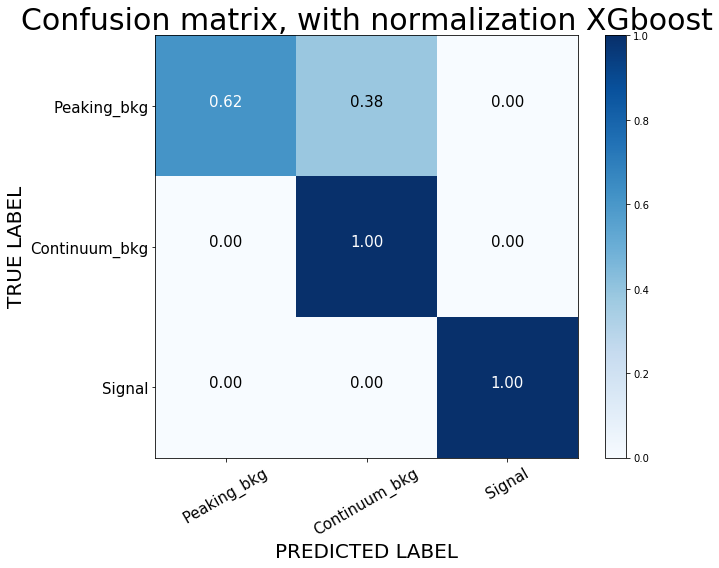

In [27]:
import itertools
plot_confusion_matrix(cnf_matrix_xg_train, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title='Confusion matrix, with normalization XGboost')

In [28]:
cnf_matrix_xg_val = confusion_matrix(Y_Validation_single_col,y_pred_val)
cnf_matrix_xg_val

array([[  196,   250,     1],
       [   12, 69754,     0],
       [    0,     0, 65969]])

Normalized confusion matrix
[[4.38478747e-01 5.59284116e-01 2.23713647e-03]
 [1.72003555e-04 9.99827996e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


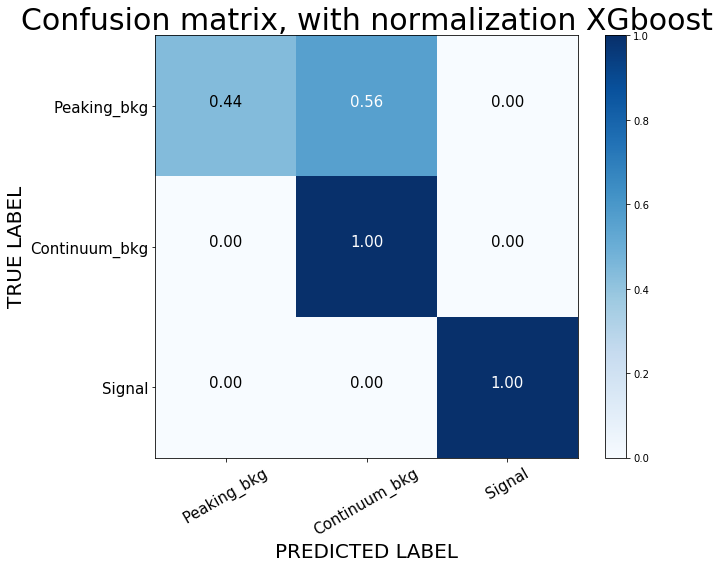

In [29]:
import itertools
plot_confusion_matrix(cnf_matrix_xg_val, classes=['Peaking_bkg', 'Continuum_bkg',"Signal"],
                      title='Confusion matrix, with normalization XGboost')

In [30]:
model_xgboost.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
              nthread=-1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed='1432',
              silent=None, subsample=1, tree_method='approx', verbosity=1)

In [34]:
joblib.dump(model_xgboost.best_estimator_, "xgboost_model.dat")

['xgboost_model.dat']

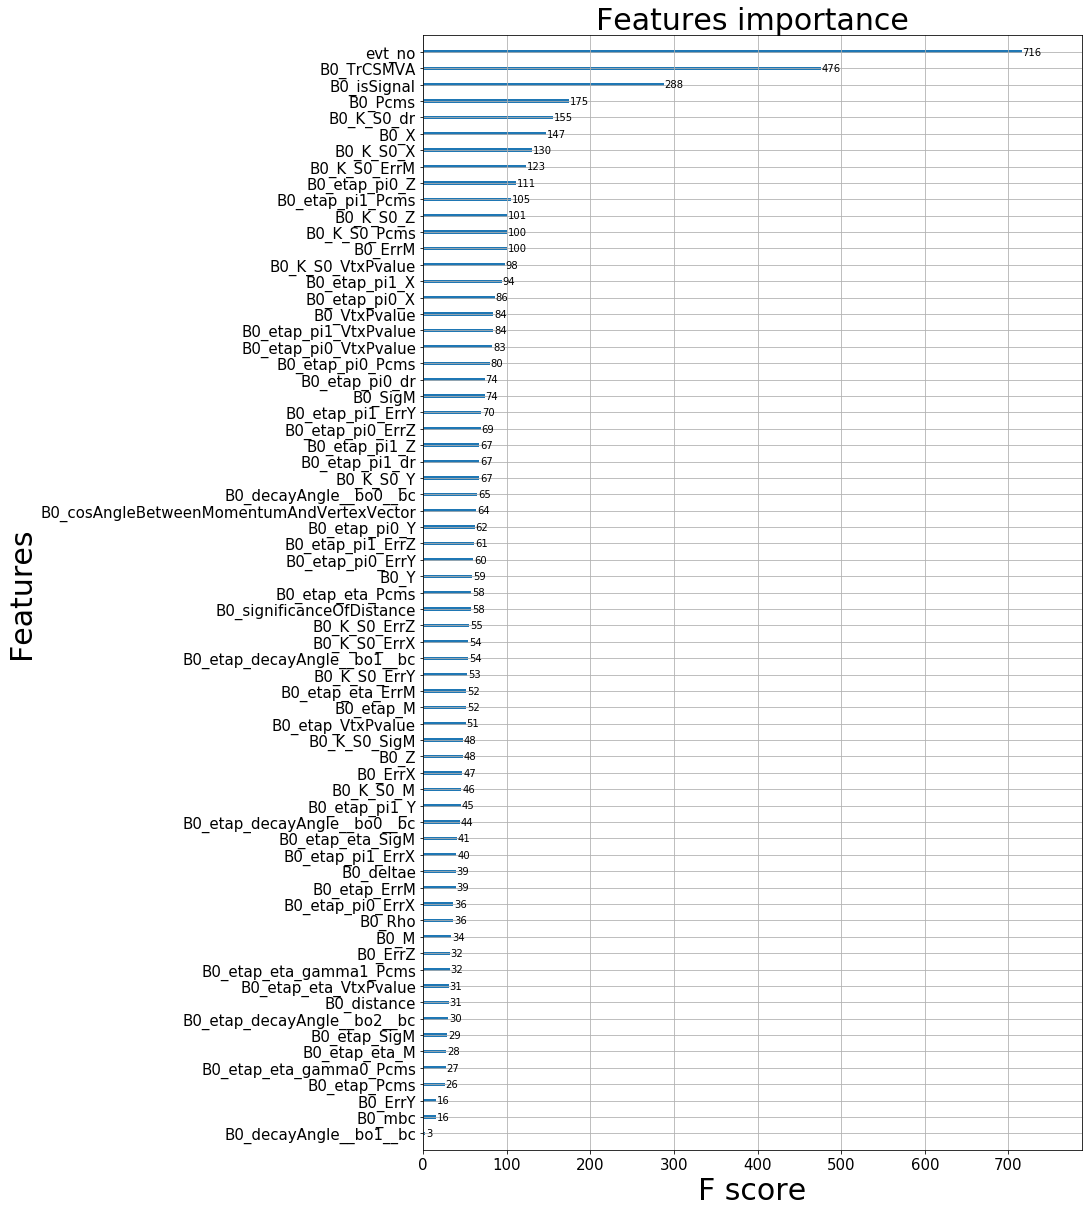

In [35]:
fig=plt.figure()
fig.set_size_inches(30.5, 20.5)
plt.tick_params(labelsize=15)
xgb.plot_importance(model_xgboost.best_estimator_, ax=plt.gca())
plt.title("Features importance",fontsize=30)
plt.ylabel("Features",fontsize=30)
plt.xlabel("F score",fontsize=30)
fig.subplots_adjust(left=0.6)  #
#fig.savefig('SUSYXGBoost1.pdf')

In [ ]:
import math
Test_prob = Loaded_Model.predict(pcTest)
Y_Test_pred = np.argmax(Test_prob, axis=1)

n_steps = 10000
cut_value = 0
to_maximize=[]
to_maximize_bis=[]
cut_values=[]

Test_df = pd.DataFrame({'Signal probability' : Test_prob[:,2],
                        'Y_true' : Ỳ_Test_not_encoded,
                        'Y_pred' : Y_Test_pred})


for i in range (0, n_steps):
    cut_value=i/n_steps 
    #cut_value = 0.98+(0.2*i)/n_steps #n_steps=1000 between 0.98 and 1
    Test_df_sel = pd.DataFrame()
    Test_df_sel = Test_df[Test_df['Signal probability']>cut_value] 
    N_tot=Test_df_sel.shape[0]
    if N_tot==0:
        print("******* ERROR!! N_tot is 0 *******")
        print(i)
        break
    #print(N_tot)
    N_true_signal = Test_df_sel[Test_df_sel['Y_true']==2].shape[0]
    #print(N_true_signal)
    N_false_signal = Test_df_sel[Test_df_sel['Y_true']!=2].shape[0]
    
    if(N_tot != (N_true_signal+N_false_signal)):
        print("****** ERROR!!! *********")
        break
    else:
        to_maximize.append(N_true_signal/math.sqrt(N_tot))
        to_maximize_bis.append(N_true_signal/math.sqrt(N_false_signal))
        cut_values.append(cut_value)
    
    
#print(to_maximize)
#print(cut_values)
#print(len(cut_values))

fig=plt.figure()
fig.set_size_inches(13.5, 9.5)
plt.tick_params(labelsize=15)
plt.plot(cut_values,to_maximize, 'o')
plt.title("Cut value maximizing Signal/sqrt(Total)",fontsize=30)
plt.xlabel("cut value on signal probability",fontsize=30)
plt.ylabel("N_signal/sqrt(N_tot)",fontsize=30)
plt.show()


fig=plt.figure()
fig.set_size_inches(13.5, 9.5)
plt.tick_params(labelsize=15)
plt.plot(cut_values,to_maximize_bis, 'o')
plt.title("Cut value maximizing Signal/sqrt(Background)",fontsize=30)
plt.xlabel("cut value on signal probability",fontsize=30)
plt.ylabel("N_signal/sqrt(N_background)",fontsize=30)
plt.show()    